<a href="https://colab.research.google.com/github/arbiter1elegantiae/kaf-nets/blob/master/FBFAdversarial_Training_KafNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install adversarial-robustness-toolbox

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import fbfadvtrain
import activationsf

from tensorflow.keras import layers 
from tensorflow.keras import initializers 
from tensorflow.keras import regularizers 
from tensorflow.keras import losses, optimizers, metrics
from tensorflow.keras import callbacks 
from tensorflow.keras.models import Sequential

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/ 255.0, x_test/ 255.0

In [4]:
tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
kaf_cnn = Sequential([
  
  # Using KAFs instead
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform',  input_shape = (32, 32, 3)),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_1'),
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_2'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2, seed=42),

  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_3'),
  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_4'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.3, seed=42),

  layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_5'),
  layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_6'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.4, seed=42),

  layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation=None, kernel_regularizer=regularizers.l2(0.0012)),
  activationsf.Kaf(D=16, name='kaf_7'),
  layers.Dropout(0.45, seed=42),
  layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.0012), dtype=tf.float32)
])

In [5]:
rob_kaf_cnn = fbfadvtrain.FastBetterFreeTrainedModel(inputs=kaf_cnn.inputs, outputs=kaf_cnn.outputs)

In [6]:
rob_kaf_cnn.compile(
              optimizer = tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
              )

Epoch 1/10
391/391 [==============================] - 165s 423ms/step - loss: 2.5052 - accuracy: 0.1010
Epoch 2/10
391/391 [==============================] - 164s 421ms/step - loss: 2.5045 - accuracy: 0.0988
Epoch 3/10
391/391 [==============================] - 164s 420ms/step - loss: 2.5050 - accuracy: 0.1000
Epoch 4/10
391/391 [==============================] - 164s 420ms/step - loss: 2.5044 - accuracy: 0.0999
Epoch 5/10
391/391 [==============================] - 164s 420ms/step - loss: 2.5050 - accuracy: 0.0997
Epoch 6/10
391/391 [==============================] - 165s 421ms/step - loss: 2.5044 - accuracy: 0.0981
Epoch 7/10
391/391 [==============================] - 164s 420ms/step - loss: 2.5033 - accuracy: 0.0992
Epoch 8/10
391/391 [==============================] - 164s 421ms/step - loss: 2.5033 - accuracy: 0.1004
Epoch 9/10
391/391 [==============================] - 165s 422ms/step - loss: 2.5027 - accuracy: 0.0987
Epoch 10/10
391/391 [==============================] - 165s 422m

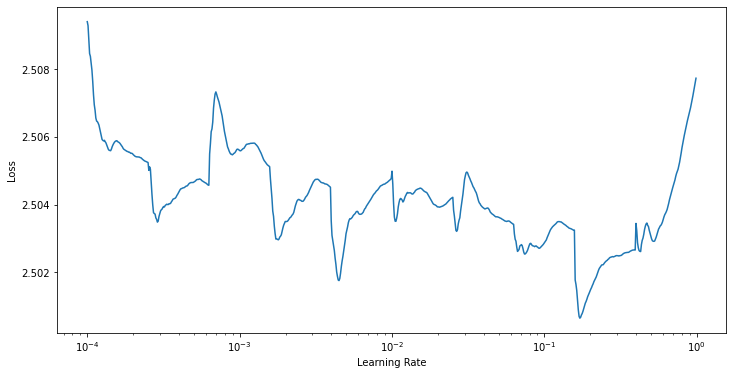

In [8]:
# Find the min max lr meaningful bounds to cycle through
# Ref: https://www.machinecurve.com/index.php/2020/02/25/training-your-neural-network-with-cyclical-learning-rates/
#!git clone https://github.com/WittmannF/LRFinder.git

from LRFinder.keras_callback import LRFinder
lr_finder = LRFinder(min_lr=1e-4, max_lr=1) # implemented as a callback

# Perform lr range test on 10 epochs
rob_kaf_cnn.fit(x_train, y_train, epochs = 10,batch_size=128, callbacks=[lr_finder])

In [7]:
# Set up cyclic learning (linear)
# ref: same as above
!git clone https://github.com/bckenstler/CLR.git
from CLR.clr_callback import CyclicLR

# Set CLR options
step_size = int(4 * (50000/128))
base_lr = 1e-4
max_lr = 2e-1
mode='triangular'

# Define the callback
clr = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=step_size, mode=mode)

Cloning into 'CLR'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 252 (delta 1), reused 4 (delta 0), pack-reused 244
Receiving objects: 100% (252/252), 2.06 MiB | 3.98 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [10]:
# Set Early Stopping
es = callbacks.EarlyStopping(
        monitor='val_accuracy',
        # "no longer improving" being defined as "no increase greater or equal than 1e-2"
        min_delta=5e-3,
        patience=10,
        mode='max', 
        verbose=1)

In [11]:
# plot diagnostic learning curves
def summarize_diagnostics(history, fine_tuning=False):
	
	if fine_tuning :
		color_train = 'green'
		color_validation = 'red'
	else :
		color_train = 'blue'
		color_validation = 'orange'

	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color=color_train, label='train')
	plt.plot(history.history['val_loss'], color=color_validation, label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color=color_train, label='train')
	plt.plot(history.history['val_accuracy'], color=color_validation, label='test')
	plt.show()
	plt.close()

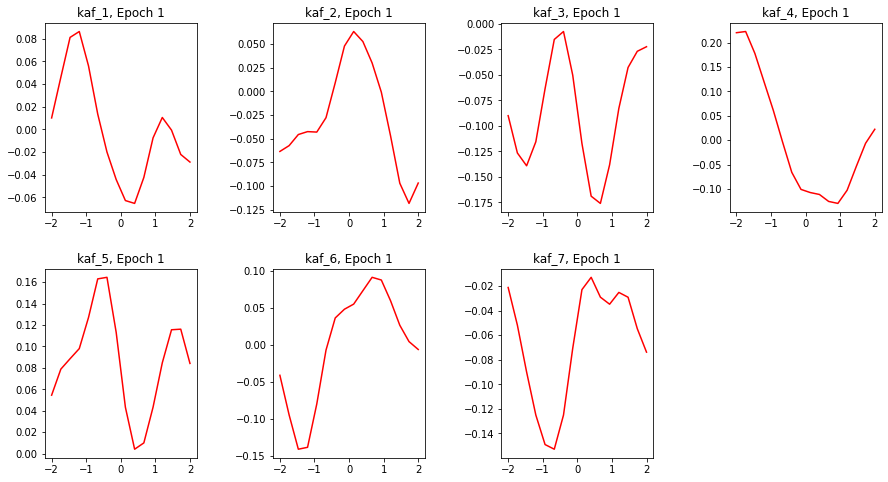

Epoch 1/100
391/391 [==============================] - 164s 420ms/step - loss: 2.4930 - accuracy: 0.0983 - val_loss: 2.4822 - val_accuracy: 0.1085


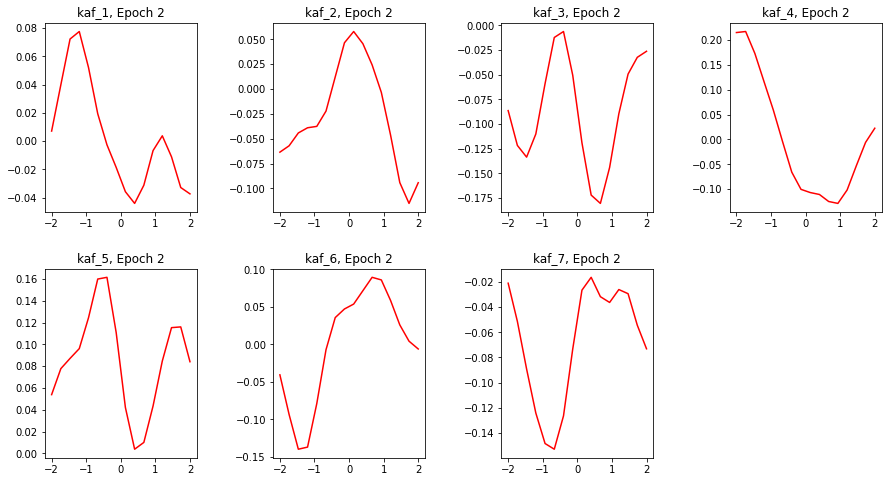

Epoch 2/100
391/391 [==============================] - 163s 418ms/step - loss: 2.4736 - accuracy: 0.1021 - val_loss: 2.4601 - val_accuracy: 0.1080


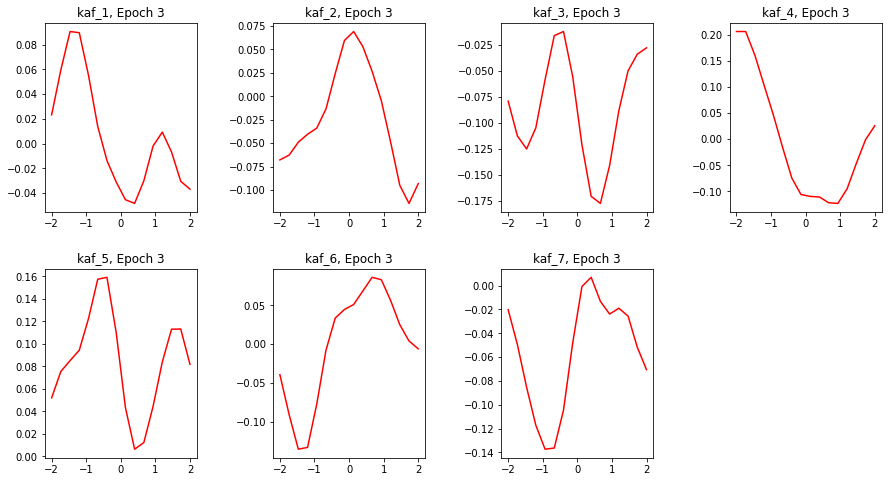

Epoch 3/100
391/391 [==============================] - 163s 417ms/step - loss: 2.4457 - accuracy: 0.1019 - val_loss: 2.4301 - val_accuracy: 0.0990


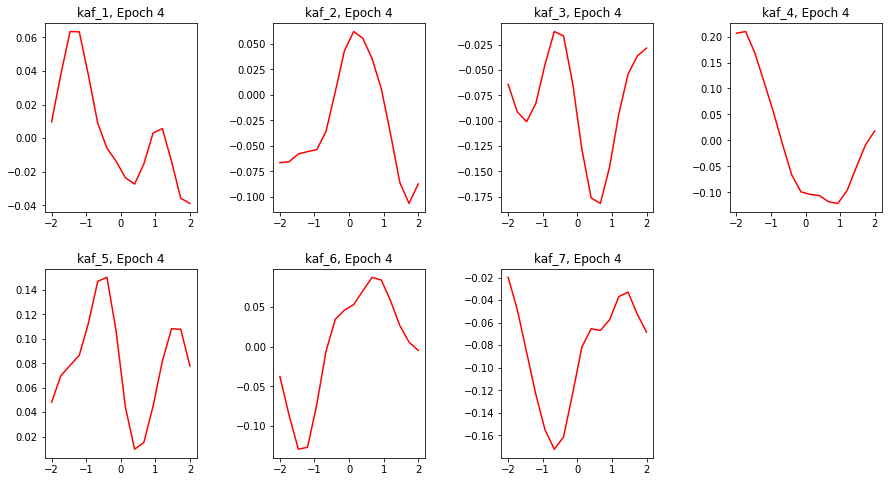

Epoch 4/100
391/391 [==============================] - 163s 417ms/step - loss: 2.4119 - accuracy: 0.0988 - val_loss: 2.3883 - val_accuracy: 0.1015


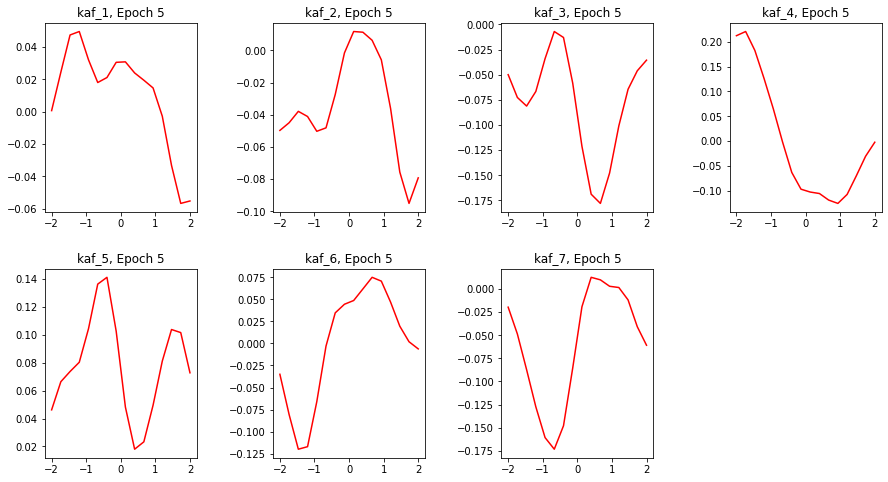

Epoch 5/100
391/391 [==============================] - 163s 417ms/step - loss: 2.1908 - accuracy: 0.1733 - val_loss: 2.1592 - val_accuracy: 0.1880


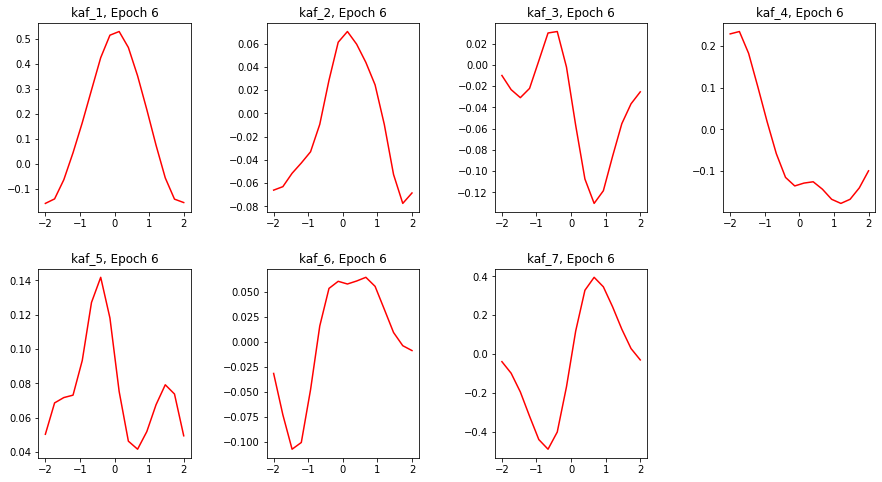

Epoch 6/100
391/391 [==============================] - 163s 417ms/step - loss: 2.0428 - accuracy: 0.2001 - val_loss: 1.9451 - val_accuracy: 0.2840


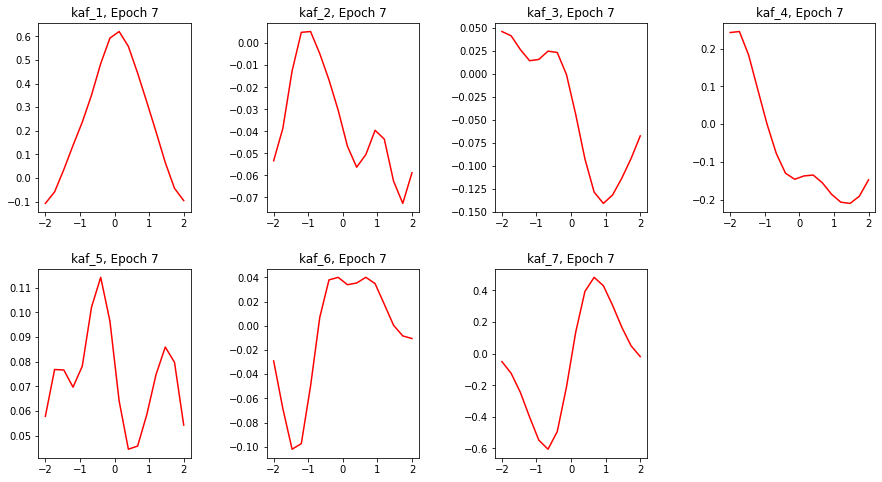

Epoch 7/100
391/391 [==============================] - 163s 417ms/step - loss: 1.9463 - accuracy: 0.2355 - val_loss: 1.8382 - val_accuracy: 0.3150


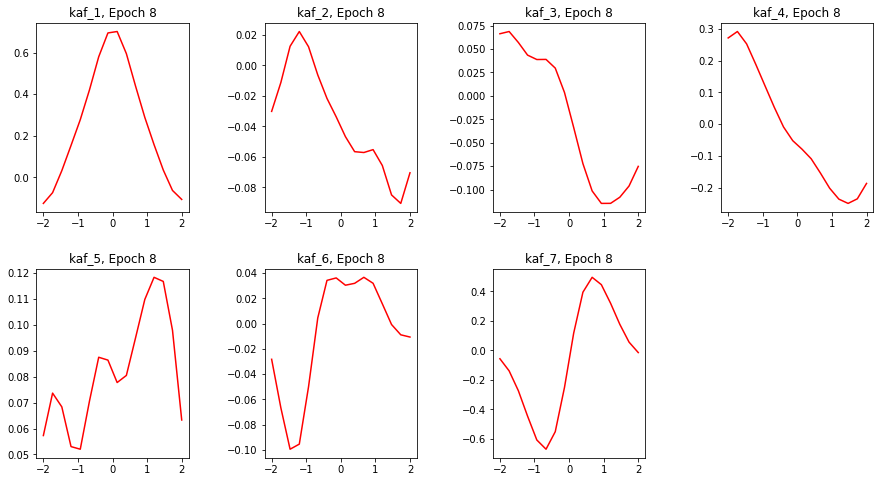

Epoch 8/100
391/391 [==============================] - 163s 417ms/step - loss: 1.9065 - accuracy: 0.2453 - val_loss: 1.7686 - val_accuracy: 0.3435


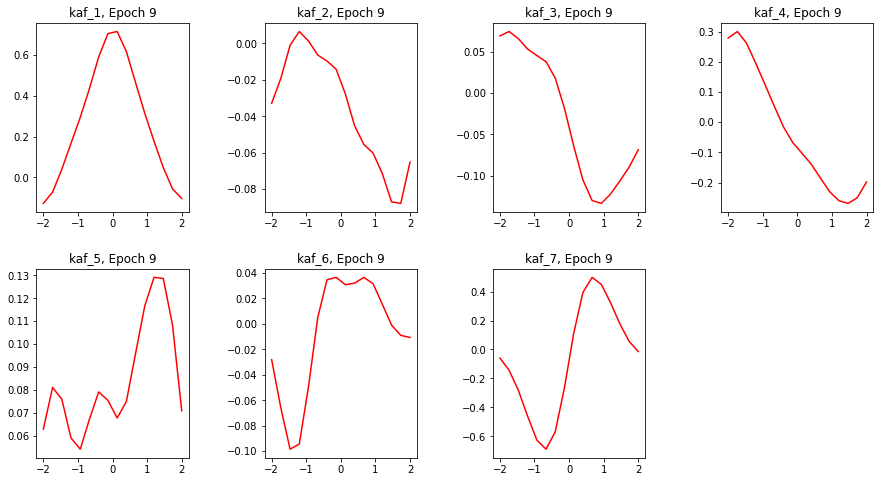

Epoch 9/100
391/391 [==============================] - 163s 417ms/step - loss: 1.8965 - accuracy: 0.2488 - val_loss: 1.7949 - val_accuracy: 0.3025


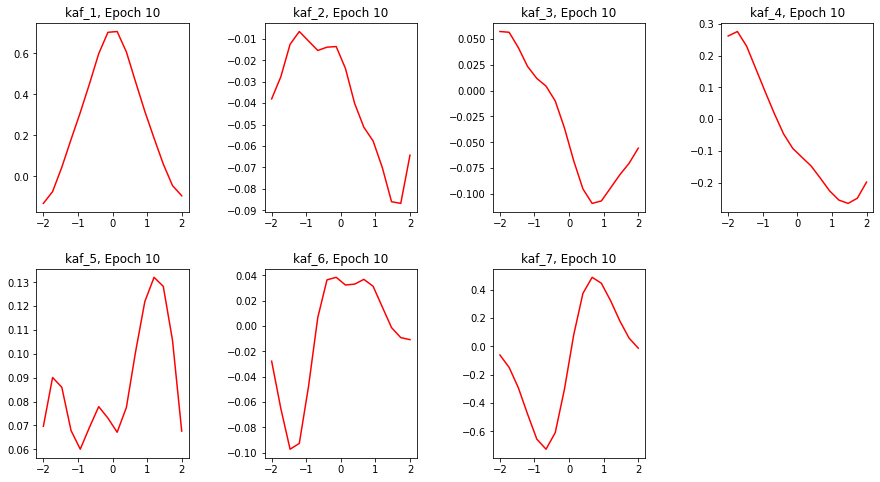

Epoch 10/100
391/391 [==============================] - 163s 417ms/step - loss: 1.8911 - accuracy: 0.2536 - val_loss: 1.7599 - val_accuracy: 0.3600


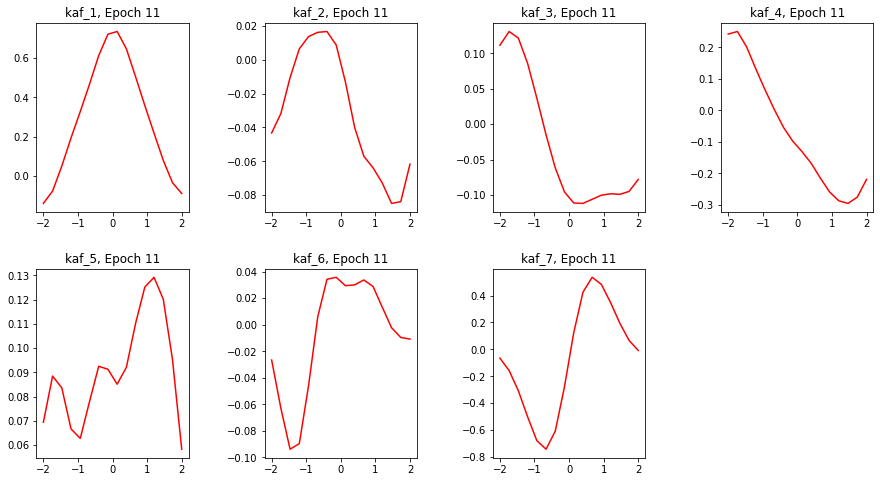

Epoch 11/100
391/391 [==============================] - 163s 417ms/step - loss: 1.8677 - accuracy: 0.2679 - val_loss: 1.7206 - val_accuracy: 0.3715


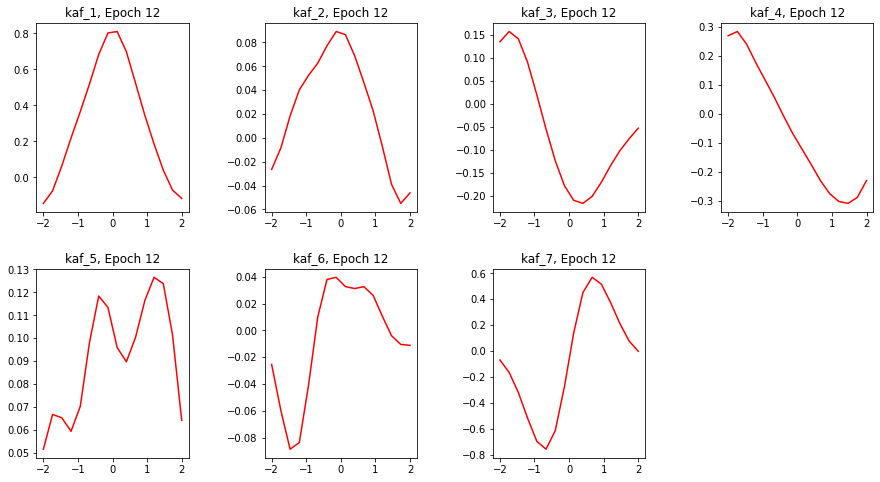

Epoch 12/100
391/391 [==============================] - 163s 417ms/step - loss: 1.8404 - accuracy: 0.2739 - val_loss: 1.8861 - val_accuracy: 0.3210


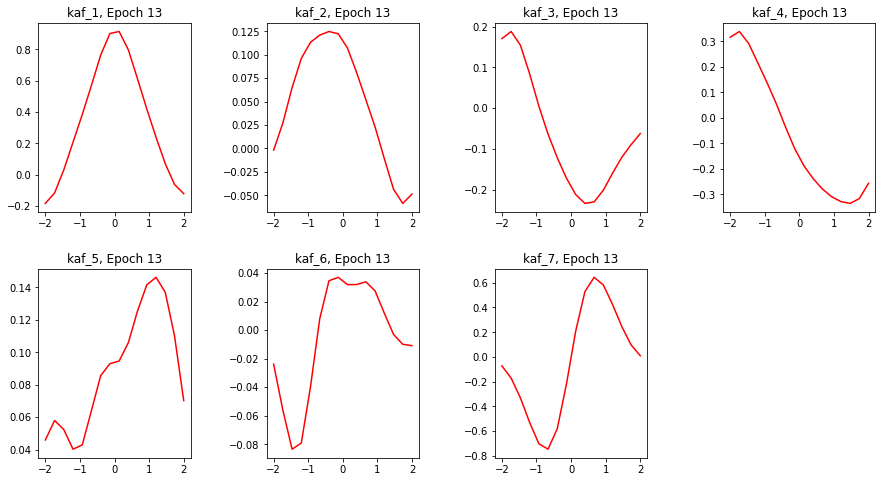

Epoch 13/100
391/391 [==============================] - 163s 417ms/step - loss: 1.8145 - accuracy: 0.2830 - val_loss: 1.6693 - val_accuracy: 0.3930


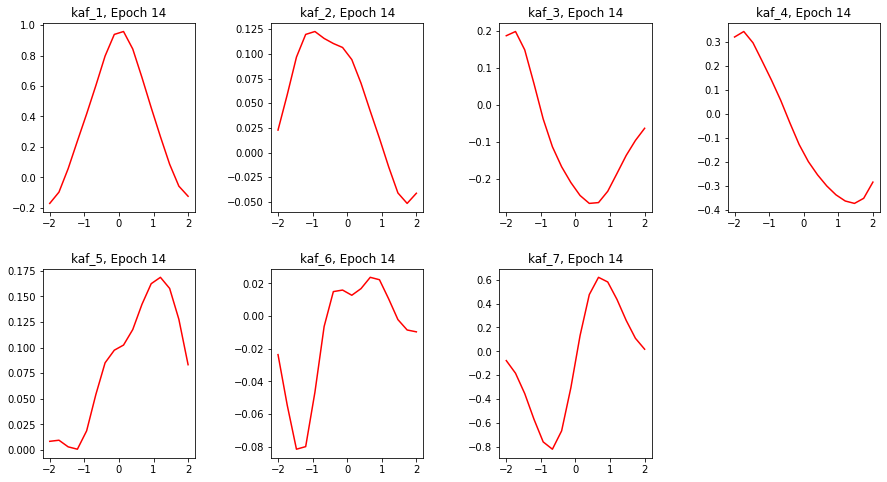

Epoch 14/100
391/391 [==============================] - 163s 417ms/step - loss: 1.7720 - accuracy: 0.3015 - val_loss: 1.5874 - val_accuracy: 0.4465


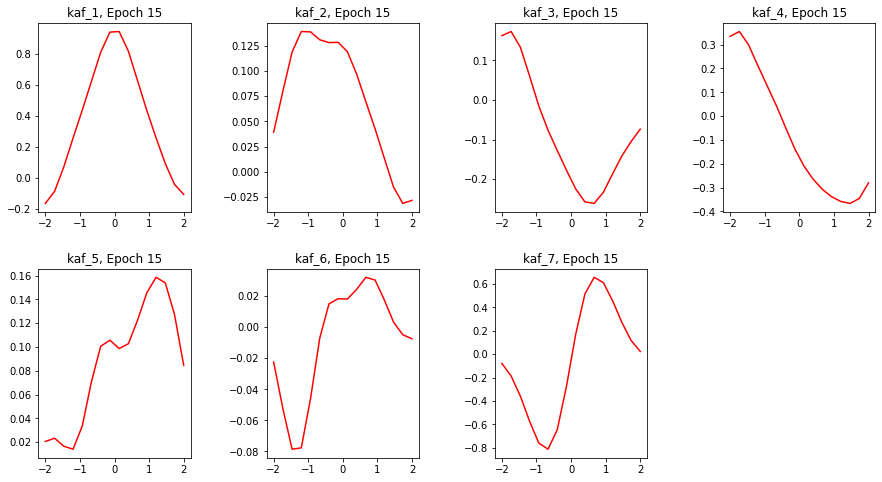

Epoch 15/100
391/391 [==============================] - 163s 417ms/step - loss: 1.7339 - accuracy: 0.3143 - val_loss: 1.5902 - val_accuracy: 0.4485


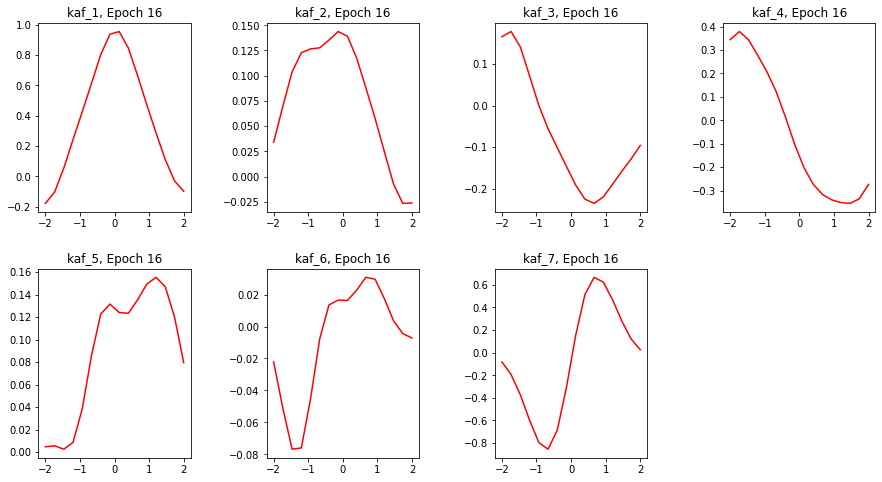

Epoch 16/100
391/391 [==============================] - 163s 417ms/step - loss: 1.7088 - accuracy: 0.3230 - val_loss: 1.5354 - val_accuracy: 0.4655


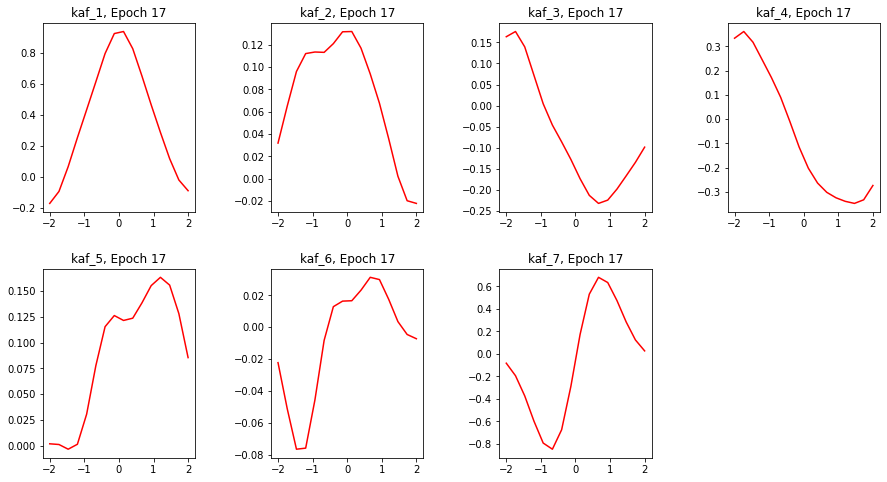

Epoch 17/100
391/391 [==============================] - 163s 417ms/step - loss: 1.7005 - accuracy: 0.3280 - val_loss: 1.5331 - val_accuracy: 0.4695


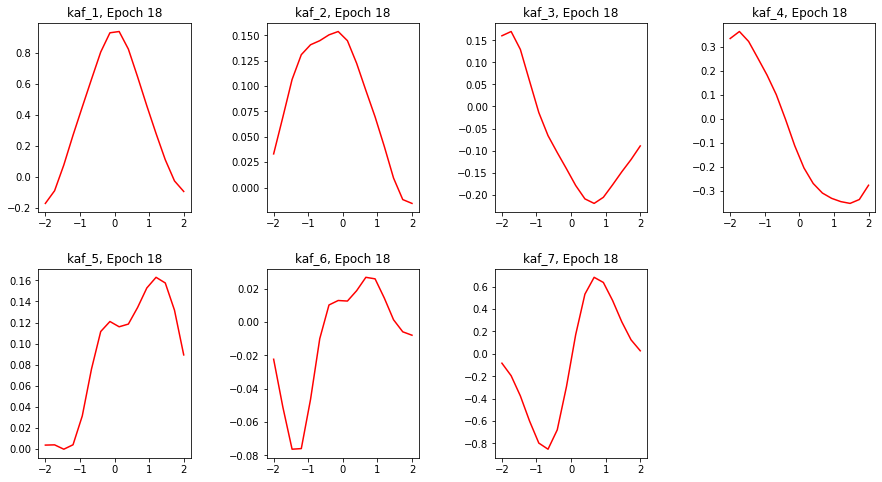

Epoch 18/100
391/391 [==============================] - 163s 416ms/step - loss: 1.7016 - accuracy: 0.3274 - val_loss: 1.6022 - val_accuracy: 0.4515


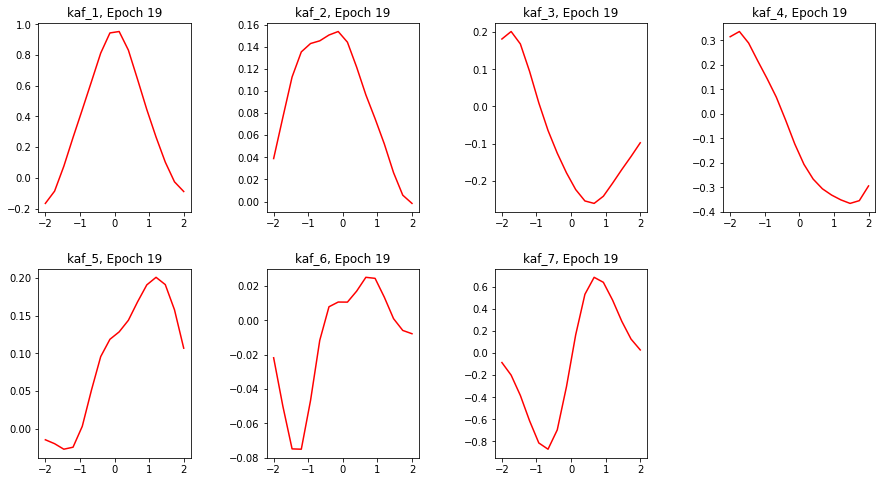

Epoch 19/100
391/391 [==============================] - 163s 416ms/step - loss: 1.7012 - accuracy: 0.3258 - val_loss: 1.5572 - val_accuracy: 0.4775


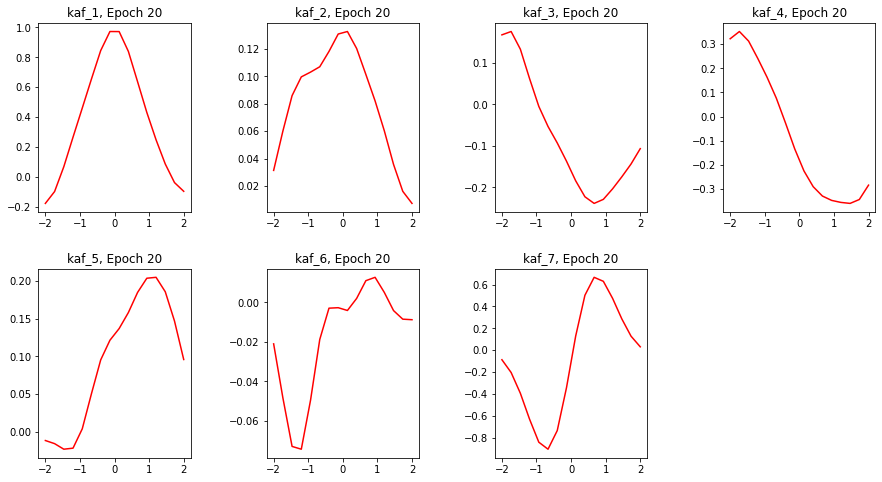

Epoch 20/100
391/391 [==============================] - 163s 416ms/step - loss: 1.6977 - accuracy: 0.3316 - val_loss: 1.6264 - val_accuracy: 0.4010


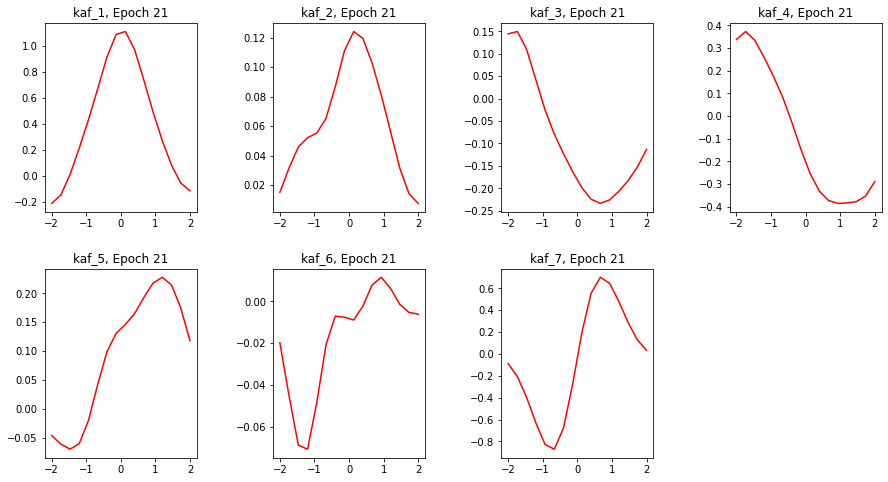

Epoch 21/100
391/391 [==============================] - 162s 415ms/step - loss: 1.6759 - accuracy: 0.3407 - val_loss: 1.4655 - val_accuracy: 0.5000


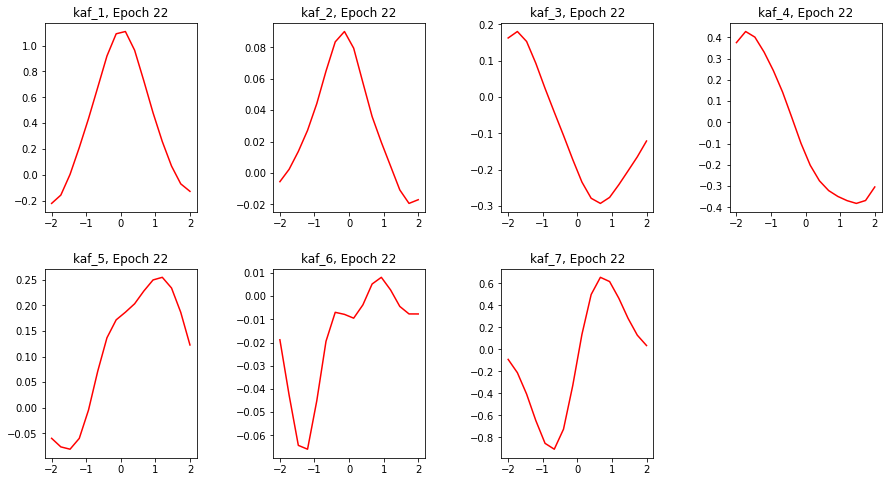

Epoch 22/100
391/391 [==============================] - 163s 416ms/step - loss: 1.6432 - accuracy: 0.3503 - val_loss: 1.4680 - val_accuracy: 0.4890


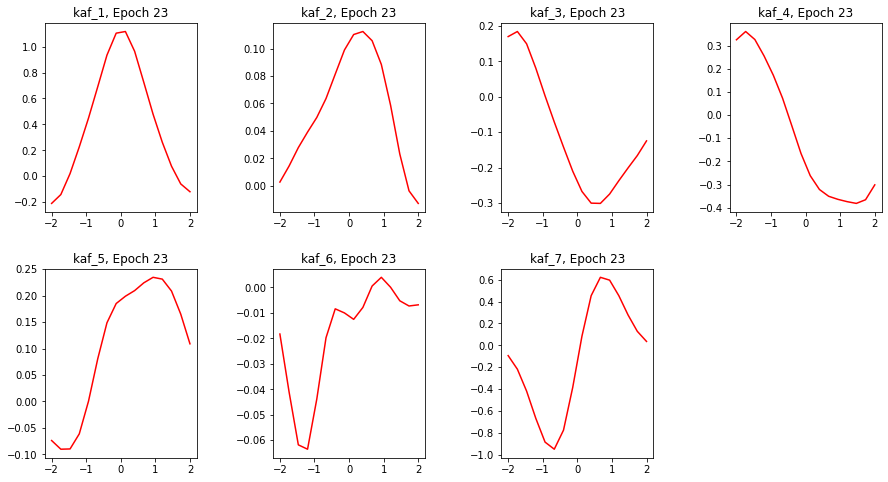

Epoch 23/100
391/391 [==============================] - 162s 416ms/step - loss: 1.6173 - accuracy: 0.3594 - val_loss: 1.3824 - val_accuracy: 0.5415


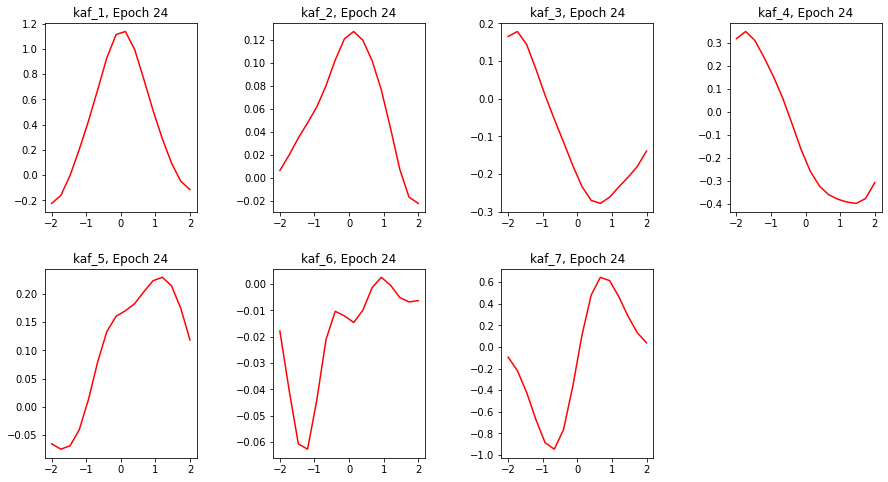

Epoch 24/100
391/391 [==============================] - 163s 416ms/step - loss: 1.5956 - accuracy: 0.3659 - val_loss: 1.3800 - val_accuracy: 0.5525


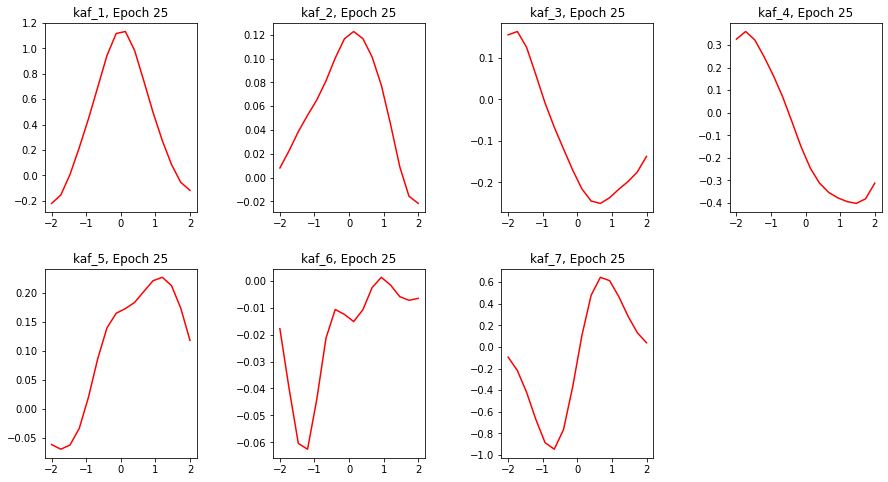

Epoch 25/100
391/391 [==============================] - 162s 415ms/step - loss: 1.5893 - accuracy: 0.3691 - val_loss: 1.4002 - val_accuracy: 0.5435


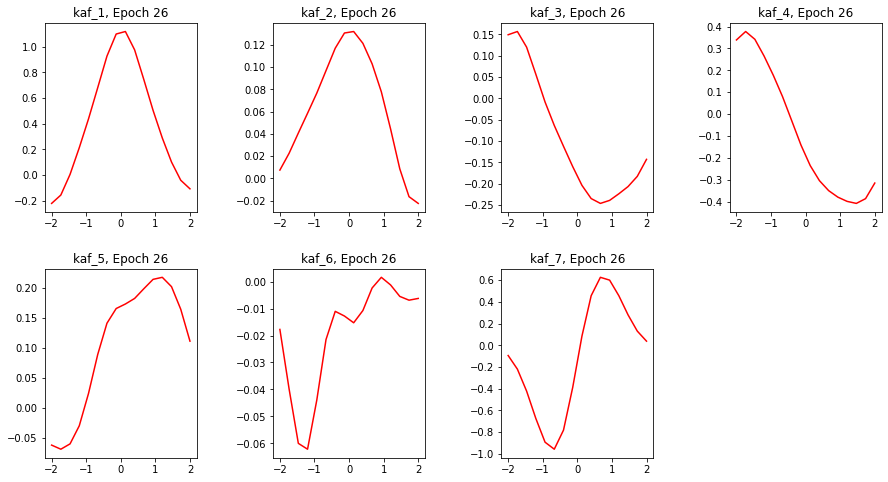

Epoch 26/100
391/391 [==============================] - 163s 416ms/step - loss: 1.5955 - accuracy: 0.3672 - val_loss: 1.3807 - val_accuracy: 0.5465


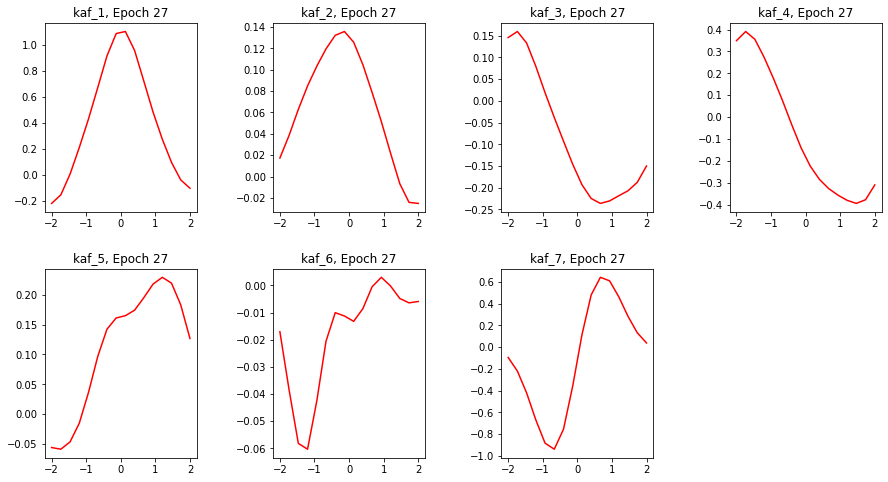

Epoch 27/100
391/391 [==============================] - 162s 416ms/step - loss: 1.6065 - accuracy: 0.3632 - val_loss: 1.4426 - val_accuracy: 0.5130


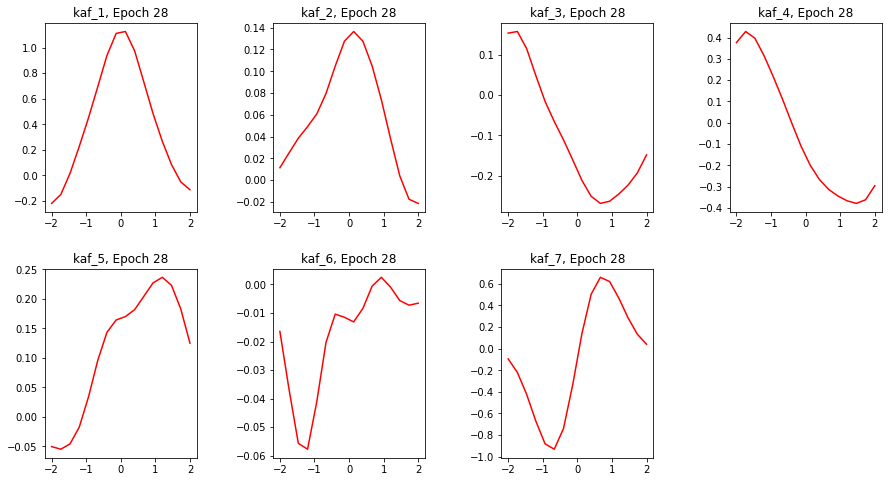

Epoch 28/100
391/391 [==============================] - 162s 416ms/step - loss: 1.6097 - accuracy: 0.3619 - val_loss: 1.4133 - val_accuracy: 0.5205


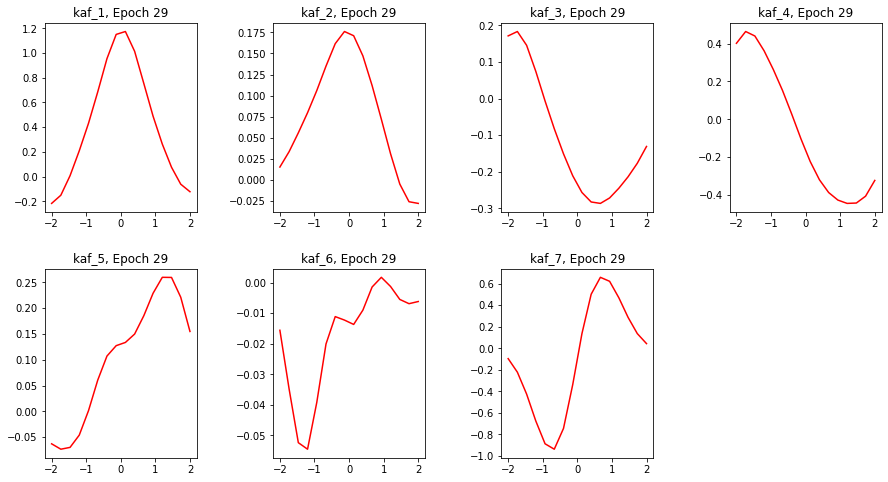

Epoch 29/100
391/391 [==============================] - 162s 416ms/step - loss: 1.5944 - accuracy: 0.3678 - val_loss: 1.3497 - val_accuracy: 0.5560


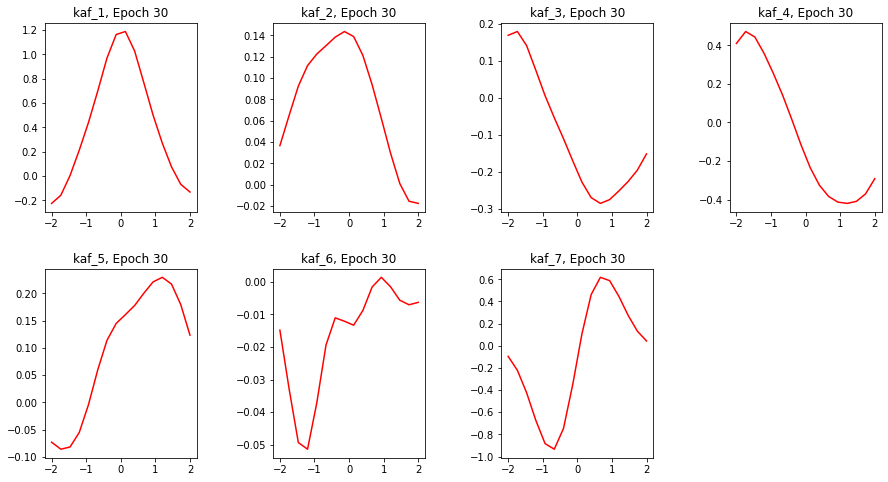

Epoch 30/100
391/391 [==============================] - 163s 416ms/step - loss: 1.5631 - accuracy: 0.3784 - val_loss: 1.3384 - val_accuracy: 0.5615


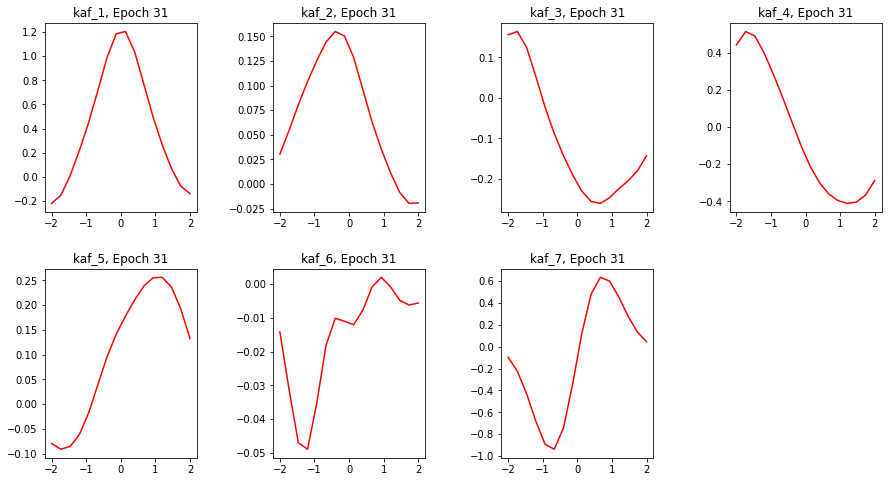

Epoch 31/100
391/391 [==============================] - 163s 416ms/step - loss: 1.5377 - accuracy: 0.3908 - val_loss: 1.3127 - val_accuracy: 0.5645


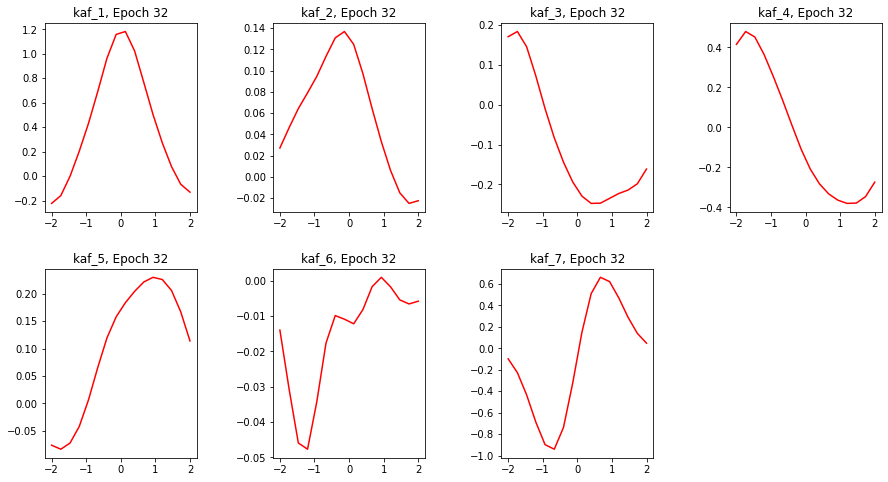

Epoch 32/100
391/391 [==============================] - 162s 416ms/step - loss: 1.5126 - accuracy: 0.3964 - val_loss: 1.2729 - val_accuracy: 0.5890


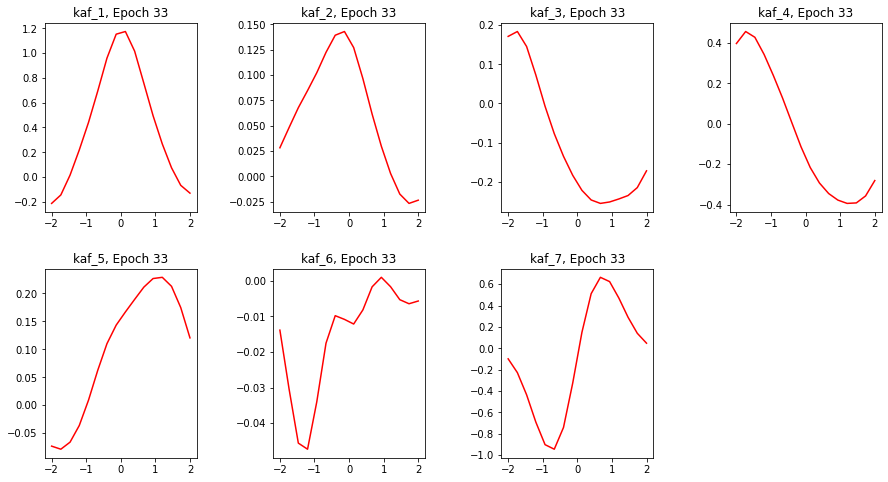

Epoch 33/100
391/391 [==============================] - 163s 416ms/step - loss: 1.5104 - accuracy: 0.3974 - val_loss: 1.2759 - val_accuracy: 0.5865


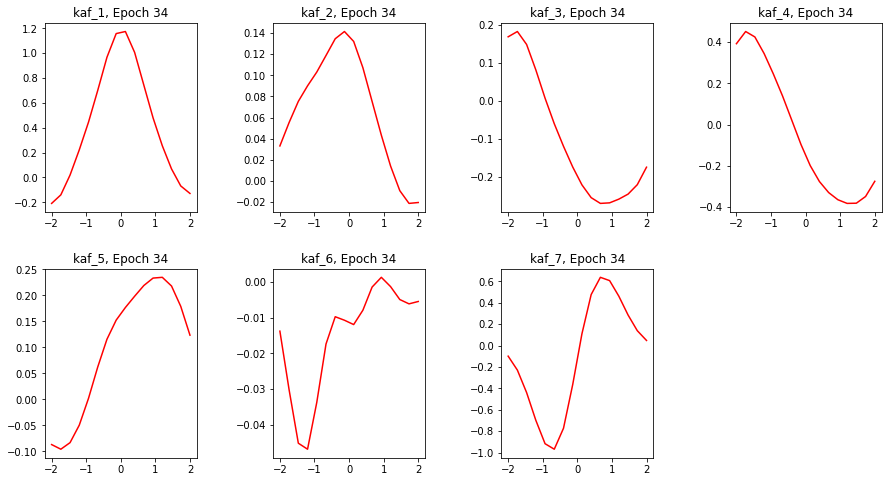

Epoch 34/100
391/391 [==============================] - 163s 416ms/step - loss: 1.5174 - accuracy: 0.3955 - val_loss: 1.3338 - val_accuracy: 0.5540


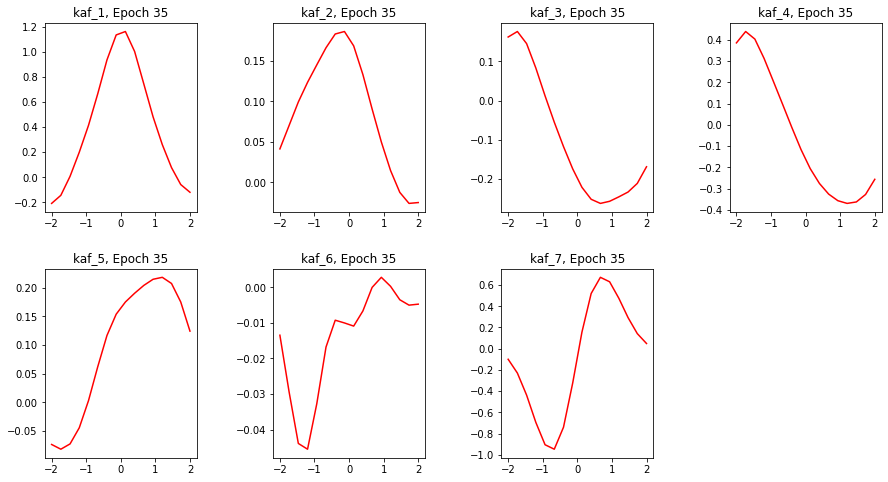

Epoch 35/100
391/391 [==============================] - 162s 416ms/step - loss: 1.5282 - accuracy: 0.3923 - val_loss: 1.5130 - val_accuracy: 0.4930


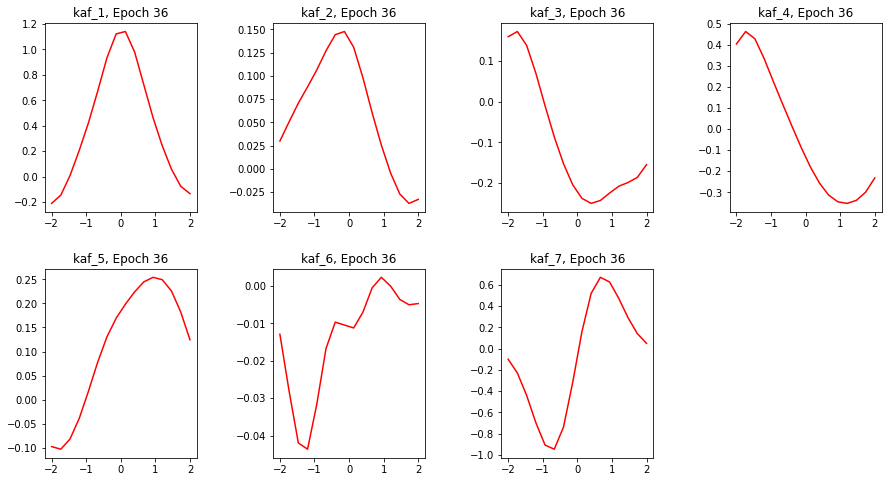

Epoch 36/100
391/391 [==============================] - 163s 417ms/step - loss: 1.5410 - accuracy: 0.3883 - val_loss: 1.4411 - val_accuracy: 0.5180


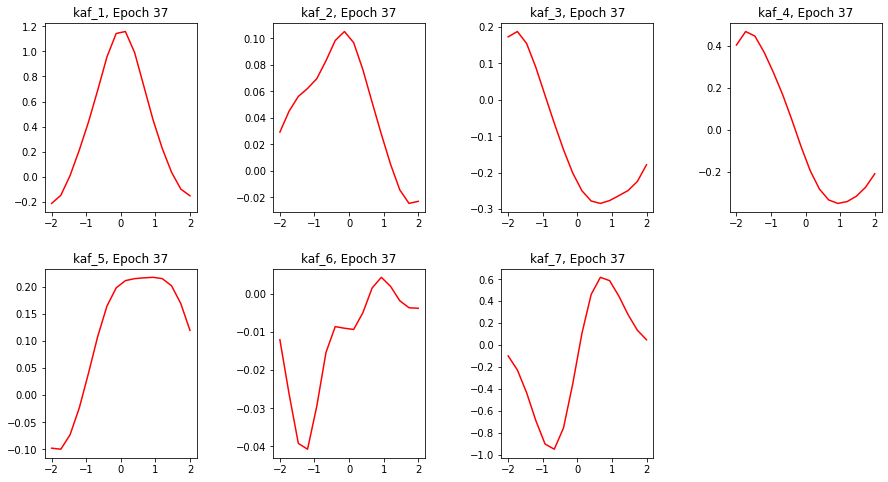

Epoch 37/100
391/391 [==============================] - 164s 419ms/step - loss: 1.5259 - accuracy: 0.3911 - val_loss: 1.3942 - val_accuracy: 0.5280


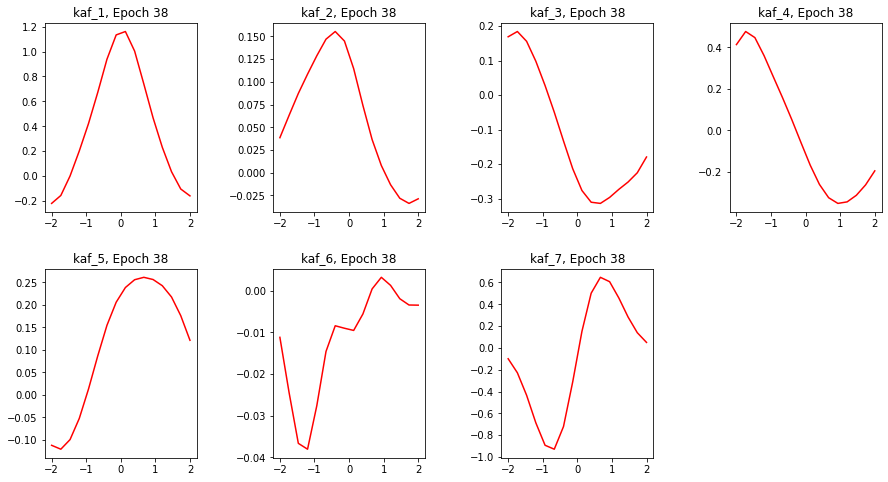

Epoch 38/100
391/391 [==============================] - 164s 419ms/step - loss: 1.4969 - accuracy: 0.4028 - val_loss: 1.2767 - val_accuracy: 0.5815


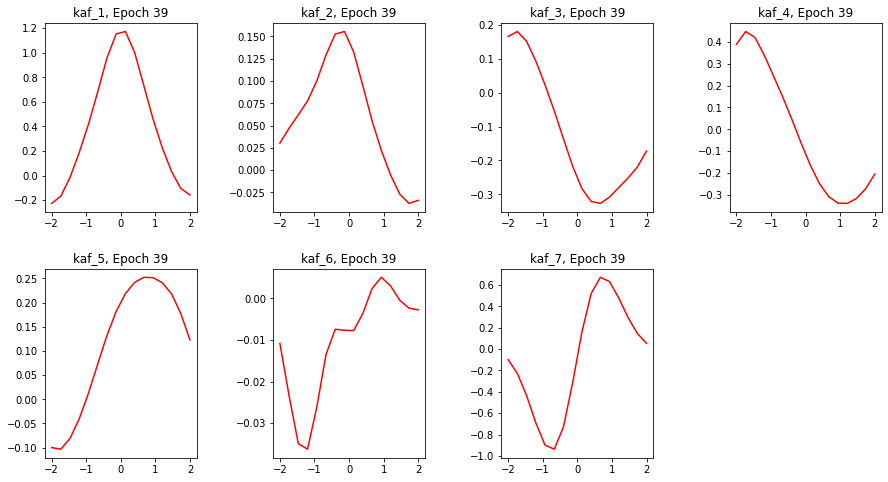

Epoch 39/100
391/391 [==============================] - 164s 419ms/step - loss: 1.4698 - accuracy: 0.4126 - val_loss: 1.2360 - val_accuracy: 0.6140


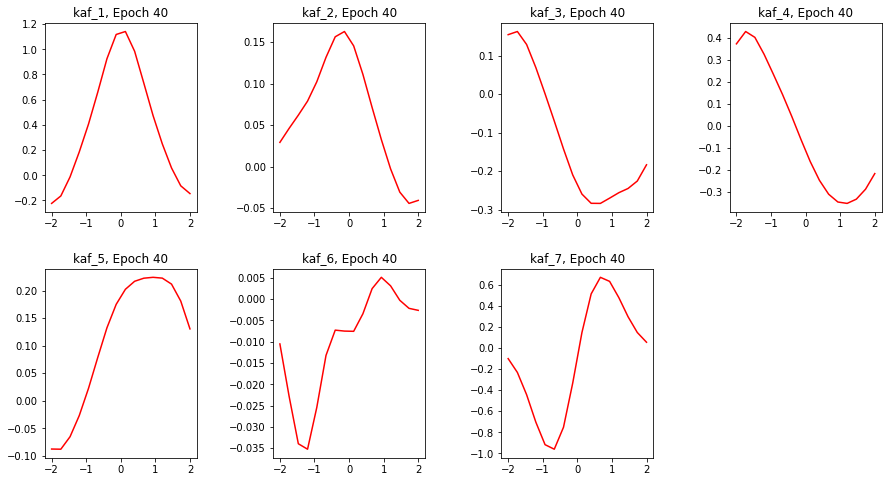

Epoch 40/100
391/391 [==============================] - 164s 419ms/step - loss: 1.4502 - accuracy: 0.4204 - val_loss: 1.2001 - val_accuracy: 0.6175


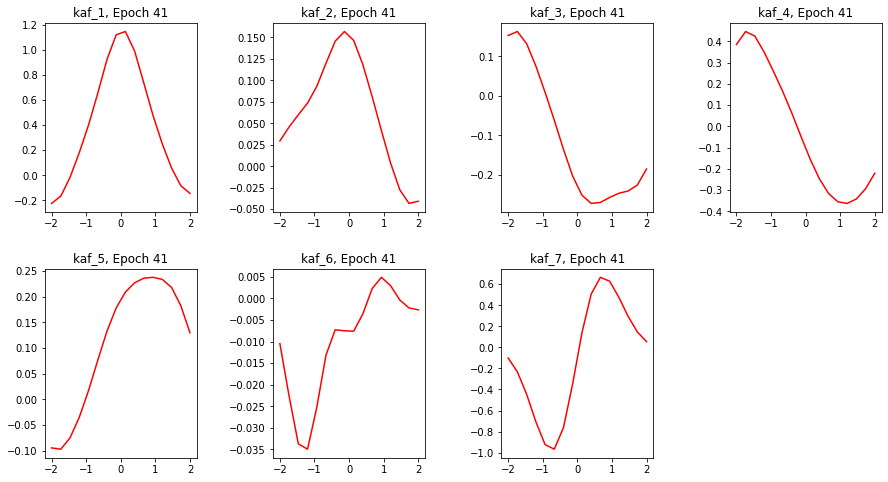

Epoch 41/100
174/391 [============>.................] - ETA: 1:29 - loss: 1.4395 - accuracy: 0.4262

KeyboardInterrupt: ignored

In [13]:
history_kaf = rob_kaf_cnn.fit(x_train, y_train, epochs = 100, validation_data=(x_test[:2000], y_test[:2000]),batch_size=128, callbacks=[es, clr, activationsf.plot_kafs_epoch_wise(num_layers=7)])

In [15]:
rob_kaf_cnn.save('/content/kaf_cnn_robust_fbf') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/kaf_cnn_robust_fbf/assets


In [17]:
!zip -r kaf_cnn_robust_fbf.zip /content/kaf_cnn_robust_fbf

  adding: content/kaf_cnn_robust_fbf/ (stored 0%)
  adding: content/kaf_cnn_robust_fbf/assets/ (stored 0%)
  adding: content/kaf_cnn_robust_fbf/saved_model.pb (deflated 90%)
  adding: content/kaf_cnn_robust_fbf/variables/ (stored 0%)
  adding: content/kaf_cnn_robust_fbf/variables/variables.index (deflated 70%)
  adding: content/kaf_cnn_robust_fbf/variables/variables.data-00001-of-00002 (deflated 8%)
  adding: content/kaf_cnn_robust_fbf/variables/variables.data-00000-of-00002 (deflated 79%)


In [19]:
from google.colab import files
files.download('/content/kaf_cnn_robust_fbf.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>